### Importing important libraries

In [92]:


# For reading stock data from yahoo
from pandas_datareader.data import DataReader
# For time stamps
from datetime import datetime
# Remote data access for pandas
import pandas_datareader as webreader
# Mathematical functions 
import math 
# Fundamental package for scientific computing with Python
import numpy as np 
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
from datetime import date, timedelta, datetime
# This function adds plotting functions for calender dates
from pandas.plotting import register_matplotlib_converters
# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 
# Formatting dates
import matplotlib.dates as mdates

In [93]:
import tensorflow as tf

In [94]:
np.random.seed()
import time
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
# Modeling
from keras.layers.recurrent import LSTM
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.regularizers import L1L2
from keras.layers import SimpleRNN
from keras import optimizers
import keras.backend as K

import sklearn
from sklearn.utils import check_array
# Evaluating models
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Normalizing the data
from sklearn.preprocessing import MinMaxScaler
# Splitting data
from sklearn.model_selection import train_test_split


ModuleNotFoundError: No module named 'keras.layers.recurrent'

## (1.) Loading data to python

In [95]:
!pip install yfinance

In [96]:
##### data: EUR/USD
##### Taking USD as a benchmark, EUR represent the currency used in Europe (France, Germany etc)

import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()


d_EURUSD= pdr.get_data_yahoo("EURUSD=X", start="2008-01-02", end="2021-05-28")
dataset = pd.DataFrame(d_EURUSD)

[*********************100%%**********************]  1 of 1 completed


In [97]:
#dataset = pd.read_csv('d_CNYUSD.csv', index_col=0 )
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,1.462309,1.474296,1.460110,1.471692,1.471692,0
2008-01-03,1.471692,1.477891,1.469400,1.474491,1.474491,0
2008-01-04,1.474709,1.481811,1.469896,1.475492,1.475492,0
2008-01-07,1.475209,1.475209,1.466706,1.468299,1.468299,0
2008-01-08,1.559211,1.559284,1.552988,1.557099,1.557099,0


In [98]:
dataset.shape

(3473, 6)

In [99]:
dataset = dataset.drop(['Adj Close','Volume'],axis = 1)

In [100]:
dataset.head(2)

,Open,High,Low,Close
Date,,,,
2008-01-02,1.462309,1.474296,1.46011,1.471692
2008-01-03,1.471692,1.477891,1.46940,1.474491


In [101]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3473 entries, 2008-01-02 to 2021-05-27
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3473 non-null   float64
 1   High    3473 non-null   float64
 2   Low     3473 non-null   float64
 3   Close   3473 non-null   float64
dtypes: float64(4)
memory usage: 135.7 KB


### Dataset consisting of only predictors (Feutures)


In [102]:
stock_dataset = dataset
stock_dataset.head()
data1 = stock_dataset[['Close']]
data1.head()

,Close
Date,
2008-01-02,1.471692
2008-01-03,1.474491
2008-01-04,1.475492
2008-01-07,1.468299
2008-01-08,1.557099


In [103]:
print('the shape of the predicting dataset is ', stock_dataset.shape)

the shape of the predicting dataset is  (3473, 4)


## (2.) Data setup for Input to RNN's

### Normalizing the data

We will normalize our data to values between 0 and 1 using the python's MinMaxScaler function. 

In [104]:
def normaliser(data,frange =(0,1)):
    #normaliser feutures
    scaler = MinMaxScaler(feature_range=frange)
    dt = data.values
    #dt = dt.reshape(-1,1)
    scaled = scaler.fit_transform(dt)
    return scaled, scaler

In [105]:
scaler1 = MinMaxScaler(feature_range = (0,1))
scaler2 = MinMaxScaler(feature_range = (0,1))
normalised_prices = scaler1.fit_transform(stock_dataset.values)
#prices_n = scaler2.fit_transform(stock_dataset[:].values)
normalised_prices[0:5] #Taking a look at our normalized values
n = scaler2.fit_transform(data1)

### Transforming the time series into well labelled training and testing dataset 

We will use the following function to transform time series into well labelled braining training and target samples. i.e we transform out input into a tuple (n_samples,n_timesteps,n_features)

In [106]:
def rnn_data_setup(data, lookback, delay, min_index, max_index):
    '''
    data:     Shape (n_samples,n_features). First column is the time series, other columns are the features.
    lookback: Number of time steps in the RNN >= 1
    delay:    The number of time steps to predict >= 1.
    min_index,max_index: The starting and ending indices of the time series portion to construct the data.
                         Allows constructing validation and test sets from the series in proper shape
    Returns: A tuple (x,y) of numpy arrays where x is in shape (n_samples,n_timesteps,n_features) and 
             y is in shape (n_samples,delay). y is an array of target arrays each of size delay. To forecast 
             a single value n timesteps ahead, set delay = n and take the last element of the forecast array.
    '''
    n_samples=(max_index+1)-min_index-(lookback-1)-delay
    samples = np.zeros((n_samples,lookback,data.shape[-1]))
    targets = np.zeros((n_samples,delay))
                  
    samp, targ = [], []
    for i in range(n_samples):  
        indices1 = range(i, i+lookback)
        indices2 = range(i + lookback, i + lookback + delay)
        samples[i] = data[indices1]
        targets[i,:] = data[indices2][0:delay][:,0] 
        #print(samples,targets)
    samp.append(samples);targ.append(targets)

    return np.array(samp)[0],np.array(targ)[0]

In [107]:
lookback =5 #Rolling period/ window of 5 and 10 days was used
delay = 1
min_index = 0
max_index = dataset.shape[0]-1
xdata, ydata = rnn_data_setup(normalised_prices, lookback, delay, min_index, max_index)
print('The shape of the input sample set is: ',  xdata.shape)
print('The shape of the target set is: ', ydata.shape)

The shape of the input sample set is:  (3468, 5, 4)
The shape of the target set is:  (3468, 1)


### Splitting the dataset into the training and testing sets

We are splitting the dataset of normalized stock prices into 80$\%$ and 20$\%$ for training and testing respectively. 20 $\%$ of training set will be assigned for validation at later stage.

In [108]:
#Specifying the sizes of training and testing datasets.
train_size = int(len(xdata)*0.6) # 2416#
valid_size = int(len(xdata)*0.2) #605#
test_size = len(xdata) - train_size-valid_size #355#

#Splitting the dataset into trainig, validation and testing.
xtrain, xvalid, xtest = xdata[0:train_size,:], xdata[train_size:train_size+valid_size,:], xdata[train_size+valid_size:len(xdata),:]
ytrain, yvalid, ytest = ydata[0:train_size,:], ydata[train_size:train_size+valid_size,:], ydata[train_size+valid_size:len(ydata),:]

print('The shape of the training sample is: ', xtrain.shape)
print('The shape of the validation sample is: ', xvalid.shape)
print('The shape of the testing sample is: ', xtest.shape)
print('The shape of the training target is: ', ytrain.shape)
print('The shape of the validation target is: ', yvalid.shape)
print('The shape of the testing target is: ', ytest.shape)

The shape of the training sample is:  (2080, 5, 4)
The shape of the validation sample is:  (693, 5, 4)
The shape of the testing sample is:  (695, 5, 4)
The shape of the training target is:  (2080, 1)
The shape of the validation target is:  (693, 1)
The shape of the testing target is:  (695, 1)


In [109]:
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], -1))
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], -1))

## Recurrent Neural Networks Models

## (A.) SimpleRNN model 

We will be are looking the best RNN model by looking the model's performance according to different variations in terms of its variables.  

#### Input variables

In [110]:
n_features = dataset.shape[1]
lr = 0.0016#Learning rate
units = 16 #Number hidden units
batch_size=64

In [ ]:
#define the model
model1 = Sequential()
model1.add(keras.layers.SimpleRNN(units, activation = 'tanh', input_shape = (lookback, n_features), return_sequences =False,recurrent_dropout=0.3))
#model1.add(Dropout(0.2))
model1.add(Dense(1))
opt = Adam(lr)#, decay=1e-6)
model1.compile(optimizer = 'Adam' , loss = 'mse', metrics=["mae"])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 16)                336       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


### (i.) Fitting the model

In [111]:
np.random.seed(1)
result1=model1.fit(xtrain,ytrain, validation_data=(xvalid,yvalid), epochs=100, verbose=1)

NameError: name 'model1' is not defined

In [ ]:
df = pd.DataFrame(result1.history)
df.tail()

,loss,mae,val_loss,val_mae
95,0.000447,0.011726,0.000094,0.007248
96,0.000452,0.011648,0.000079,0.006702
97,0.000479,0.012520,0.000131,0.009347
98,0.000436,0.011140,0.000075,0.006643
99,0.000435,0.011274,0.000119,0.008400


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


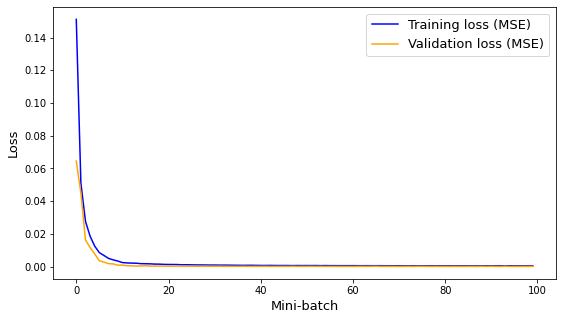

In [ ]:
print('')
plt.figure(figsize=(9,5))
plt.plot(df['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(df['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('RNN_error1.eps', format='eps', dpi=1000)
plt.show()

### (ii.) Predictions

Now we will use our model to make predictions.

In [ ]:
preds1 = model1.predict(xtest)
preds1.shape

(695, 1)

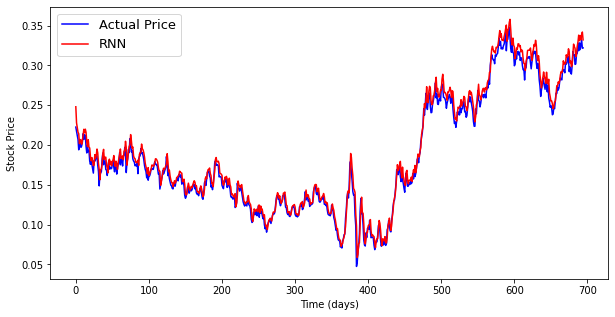

In [ ]:
print('')
plt.figure(figsize=(10,5))
plt.plot(ytest, label="Actual Price", color = 'blue')
plt.plot(preds1, label="RNN", color = 'red')
plt.xlabel('Time (days)')
plt.ylabel('Stock Price')
plt.legend(fontsize=13)
plt.show()

In [ ]:
#actuals = scaler2.inverse_transform(xtest)
real_pred1 = scaler2.inverse_transform(preds1)

In [ ]:
ytest=ytest.reshape(-1, 1)
actuals = scaler2.inverse_transform(ytest)

#### Plot of Actual Stock Prices

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


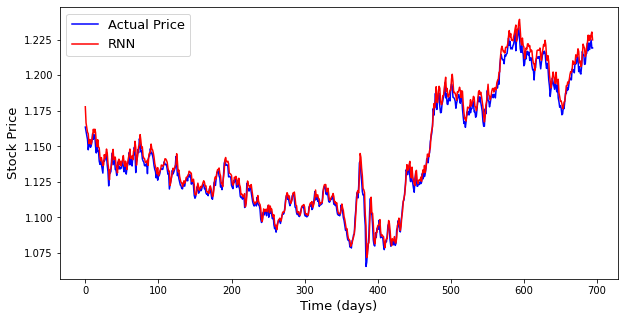

In [ ]:
print('')
plt.figure(figsize=(10,5))
plt.plot(actuals, label="Actual Price", color = 'blue')
plt.plot(real_pred1, label="RNN", color = 'red')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('RNN_model1.eps', format='eps', dpi=1000)
plt.show()

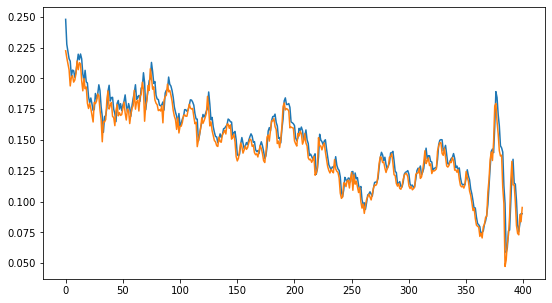

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(preds1[:400,:])
plt.plot(ytest[:400,:])
plt.show()

### (iii.) RNN Model MSE

In [ ]:
print('The the mean squared error committed by the standard RNN model is ', mean_squared_error(actuals,real_pred1))
print('The squaroot of the mean squared error committed by the standard RNN model is ', np.sqrt(mean_squared_error(actuals,real_pred1)))

The the mean squared error committed by the standard RNN model is  2.684582672548734e-05
The squaroot of the mean squared error committed by the standard RNN model is  0.0051812958538851395


### (iv.) RNN Model MAPE

In [ ]:
from keras.metrics import mean_absolute_percentage_error #MeanAbsolutePercentageError

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_pred)) * 100

In [ ]:
print('The the mean absolute percentage error committed by the standard RNN model is: ', mean_absolute_percentage_error(actuals,real_pred1))

The the mean absolute percentage error committed by the standard RNN model is:  0.34169240579896637


### (v.) RNN Model MAE

In [ ]:
print('The the mean absolute error committed by the standard RNN model is: ', mean_absolute_error(actuals,real_pred1))

The the mean absolute error committed by the standard RNN model is:  0.003949970510757619


## (B.) LSTM Model

In [ ]:
# Define the LSTM model
model2 = Sequential()
model2.add(LSTM(32, activation='tanh',input_shape = (lookback,dataset.shape[1]),return_sequences = True))#,recurrent_dropout=0.3))
#model2.add(LSTM(32),return_sequences = True))                 #,activation='tanh', return_sequences = True,recurrent_dropout=0.2))
#model2.add(Dropout(0.5))
model2.add(LSTM(32))
#model2.add(Dropout(0.5))
model2.add(Dense(1))
opt = Adam(lr=0.02)#, decay=1e-6)
model2.compile(loss='mse', optimizer=opt , metrics=["mae"])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 32)             4736      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,089
Trainable params: 13,089
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### (i.) Fitting the model

In [ ]:
#n_epochs =100
#valid_score = 0.2
start = time.time()
np.random.seed(1)
result2 = model2.fit(xtrain,ytrain,batch_size=300,epochs=150,validation_data=(xvalid,yvalid), verbose = 1)
print("> Compilation Time : ", time.time() - start)

Epoch 1/150
7/7 [==============================] - 5s 191ms/step - loss: 0.1021 - mae: 0.2692 - val_loss: 0.0396 - val_mae: 0.1916
Epoch 2/150
7/7 [==============================] - 0s 21ms/step - loss: 0.0239 - mae: 0.1250 - val_loss: 0.0171 - val_mae: 0.1217
Epoch 3/150
7/7 [==============================] - 0s 21ms/step - loss: 0.0166 - mae: 0.1013 - val_loss: 0.0282 - val_mae: 0.1670
Epoch 4/150
7/7 [==============================] - 0s 23ms/step - loss: 0.0072 - mae: 0.0703 - val_loss: 0.0021 - val_mae: 0.0435
Epoch 5/150
7/7 [==============================] - 0s 21ms/step - loss: 0.0029 - mae: 0.0436 - val_loss: 0.0106 - val_mae: 0.1010
Epoch 6/150
7/7 [==============================] - 0s 21ms/step - loss: 0.0023 - mae: 0.0382 - val_loss: 7.0566e-04 - val_mae: 0.0230
Epoch 7/150
7/7 [==============================] - 0s 21ms/step - loss: 0.0015 - mae: 0.0285 - val_loss: 0.0010 - val_mae: 0.0285
Epoch 8/150
7/7 [==============================] - 0s 20ms/step - loss: 0.0013 - mae:

In [ ]:
df2 = pd.DataFrame(result2.history)
df2.tail()

,loss,mae,val_loss,val_mae
145,0.000392,0.011366,0.000096,0.007453
146,0.000411,0.012000,0.000095,0.007393
147,0.000394,0.011421,0.000134,0.009224
148,0.000418,0.012154,0.000099,0.007656
149,0.000399,0.011564,0.000122,0.008729


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


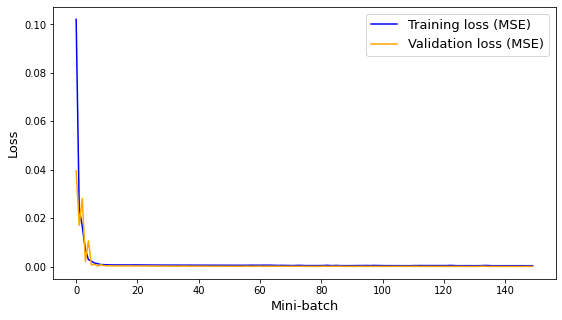

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(df2['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(df2['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('LSTM1_error.eps', format='eps', dpi=1000)
plt.show()

### (ii.) Predictions

In [ ]:
# Doing a prediction on all the test data at once
preds2 = model2.predict(xtest)

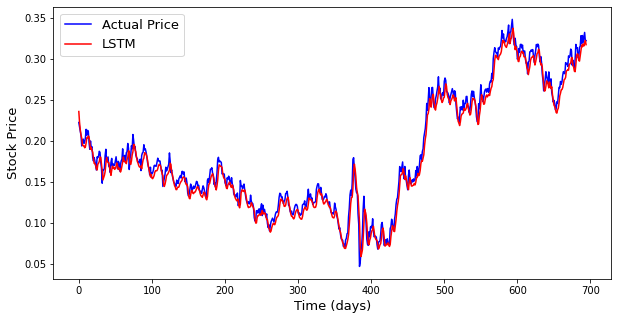

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(ytest, label="Actual Price", color = 'blue')
plt.plot(preds2, label="LSTM", color = 'red')
plt.xlabel('Time (days)')
plt.ylabel('Stock Price')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.show()

In [ ]:
real_pred2 = scaler2.inverse_transform(preds2)

In [ ]:
ytest=ytest.reshape(-1, 1)
actuals = scaler2.inverse_transform(ytest)

#### Plot of Actual Stock Prices

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


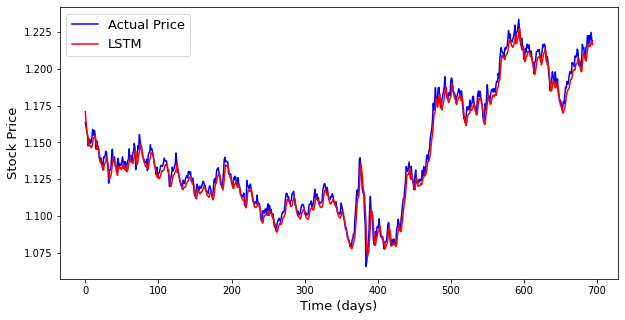

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(actuals, label="Actual Price", color = 'blue')
plt.plot(real_pred2, label="LSTM", color = 'red')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('LSTM_model1.eps', format='eps', dpi=1000)
plt.show()

### (iii.) LSTM Model MSE

In [ ]:
print('The the mean squared error committed by the LSTM model is ', mean_squared_error(actuals,real_pred2))
print('The squareroot of the mean squared error committed by the LSTM model is ', np.sqrt(mean_squared_error(actuals,real_pred2)))

The the mean squared error committed by the LSTM model is  3.0944125799737307e-05
The squareroot of the mean squared error committed by the LSTM model is  0.0055627444485377275


### (iv.) LSTM Model MAPE

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_pred)) * 100

In [ ]:
print('The the mean squared error committed by the  model is: ', mean_absolute_percentage_error(actuals,real_pred2))

The the mean squared error committed by the  model is:  0.3855383404935366


### (v.) RNN MAE

In [ ]:
print('The the mean absolute error committed by the standard RNN model is: ', mean_absolute_error(actuals,real_pred2))

The the mean absolute error committed by the standard RNN model is:  0.004399232282595677


## (C.) GRU Model

In [ ]:
! pip install tensorflow

In [ ]:
import tensorflow as tf

In [ ]:
n_features =dataset.shape[1]
# define model
model3 = Sequential()
model3.add(keras.layers.GRU(128, activation='tanh', input_shape=(lookback, n_features)))
model3.add(Dropout(0.1801))
model3.add(Dense(1))
opt = tf.keras.optimizers.Adam(lr=0.0114)
model3.compile(optimizer = opt, loss='mse', metrics=["mae"])
model3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               51456     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 51,585
Trainable params: 51,585
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### (i.) Fitting the model

In [ ]:
n_epochs = 150
valid_score = 0.2
start = time.time()
result3 = model3.fit(xtrain,ytrain,batch_size=200,epochs=n_epochs,validation_split=valid_score, verbose = 0)
model3.reset_states()
print("> Compilation Time : ", time.time() - start)

> Compilation Time :  84.02622437477112


In [ ]:
df3 = pd.DataFrame(result3.history)
df3.tail()

,loss,mae,val_loss,val_mae
145,0.000727,0.017798,0.000623,0.020427
146,0.000711,0.017599,0.000293,0.014006
147,0.000705,0.017830,0.000247,0.012822
148,0.000783,0.019061,0.000559,0.019260
149,0.000703,0.017705,0.000364,0.015228


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


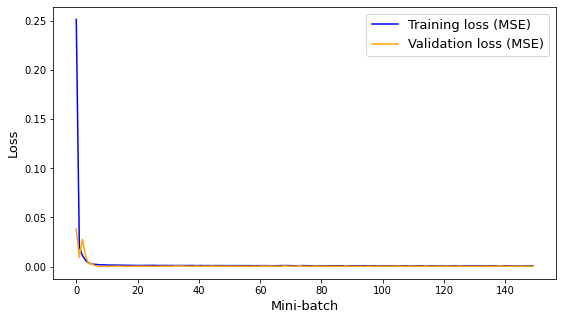

In [ ]:
print('')
plt.figure(figsize=(9,5))
plt.plot(df3['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(df3['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('GRU1_error.eps', format='eps', dpi=1000)
plt.show()

### (ii.) Predictions

In [ ]:
preds3 = model3.predict(xtest)

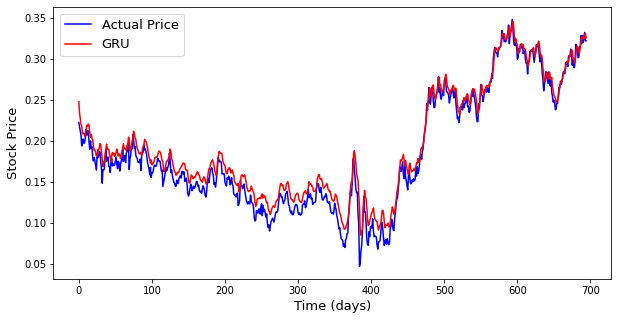

In [ ]:
print('')
plt.figure(figsize=(10,5))
plt.plot(ytest, label="Actual Price", color = 'blue')
plt.plot(preds3, label="GRU", color = 'red')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.show()

In [ ]:
real_pred3 = scaler2.inverse_transform(preds3)

In [ ]:
ytest=ytest.reshape(-1, 1)
actuals = scaler2.inverse_transform(ytest)

#### Plot of Actual Stock Prices

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


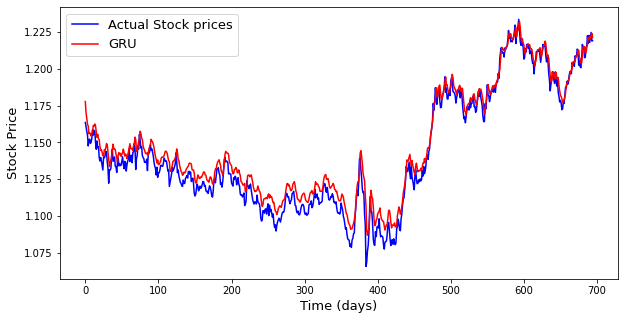

In [ ]:
print('')
plt.figure(figsize=(10,5))
plt.plot(actuals, label="Actual Stock prices", color = 'blue')
plt.plot(real_pred3, label="GRU", color = 'red')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('GRU_model1.eps', format='eps', dpi=1000)
plt.show()

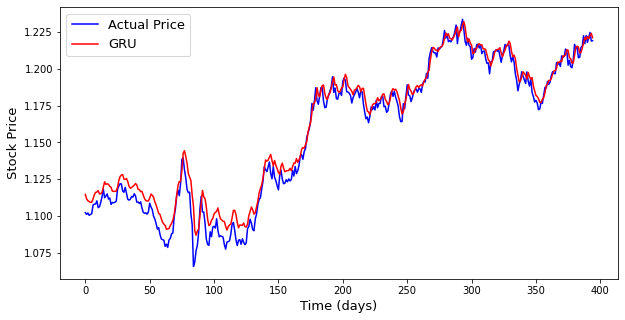

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(actuals[300:], label="Actual Price", color = 'blue')
plt.plot(real_pred3[300:], label="GRU", color = 'red')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.show()

### (iii.) GRU Model MSE

In [ ]:
print('The the mean squared error committed by the GRU model is ', mean_squared_error(actuals,real_pred3))
print('The squareroot of the mean squared error committed by the GRU model is ', np.sqrt(mean_squared_error(actuals,real_pred3)))

The the mean squared error committed by the GRU model is  6.078387491452664e-05
The squareroot of the mean squared error committed by the GRU model is  0.007796401407991167


### (iv.) GRU Model MAPE

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_pred)) * 100

In [ ]:
print('The the mean absolute percentage error committed by the GRU model is: ', mean_absolute_percentage_error(actuals,real_pred3))

The the mean absolute percentage error committed by the GRU model is:  0.5762066674594333


 ### (v.) GRU MAE

In [ ]:
print('The the mean absolute error committed by the standard RNN model is: ', mean_absolute_error(actuals,real_pred3))

The the mean absolute error committed by the standard RNN model is:  0.006545413017913936


## (D.) Combined Models

### Predicted Prices

In [ ]:
Pred_Data=pd.DataFrame({'RNN':real_pred1[:,0],'LSTM':real_pred2[:,0],'GRU':real_pred3[:,0], 'Actual Price':actuals[:,0]})
Pred_Data.head()

,RNN,LSTM,GRU,Actual Price
0,1.177839,1.171009,1.177766,1.163551
1,1.166496,1.163678,1.170140,1.160359
2,1.163305,1.158614,1.166112,1.157613
3,1.159925,1.154893,1.162414,1.154894
4,1.158867,1.152882,1.160970,1.147577


In [ ]:
#saving dataset of predicted prices
Pred_Data.to_csv('Pred_Data1.csv', sep = ',', header = True)

### Combined Plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


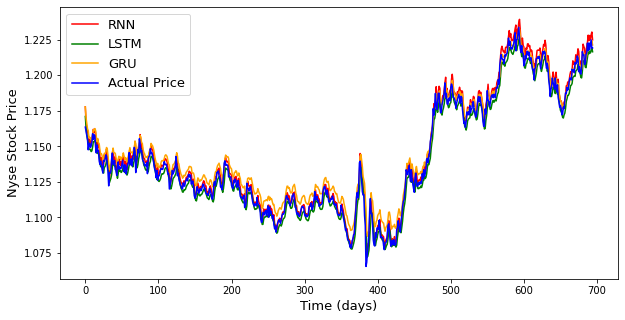

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(Pred_Data['RNN'], color = 'red', label = 'RNN')
plt.plot(Pred_Data['LSTM'], color = 'green', label = 'LSTM')
plt.plot(Pred_Data['GRU'], color = 'orange', label = 'GRU')
plt.plot(actuals, color = 'blue', label = 'Actual Price')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Nyse Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('Combined1.eps', format='eps', dpi=1000)
plt.show()